<a href="https://colab.research.google.com/github/AlexandraLJones/FIRE-CloudComputing/blob/main/TheFinalFour_FinalDeliverable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FIRE198 Final Project
Team Members: Valerie Gorden, Henry Starr, Shraddha Patre, Benjamin Varghese

##Introduction

GLOBE Clouds is a NASA program that allows civilians to upload images of clouds to a large dataset in order to train a model that can accurately identify clouds. One of the many purposes of GLOBE Clouds is to train a model so that it can spot areas with certain cloud coverage that might be favorable for solar energy production. Some clouds, such as thin high-level clouds, are conducive to solar energy production, so identifying these areas would be helpful when planning where to put a new solar field.

The main objective of this deliverable is to try to identify any possible weaknesses within the GLOBE Clouds teachable model. We are focusing mainly on cirrus and cirrostratus data in this particular deliverable. Images will be fed into the current model to see how the teachable machine correctly classifies and misclassifies images. Once the images have been classified, we are going to look at other columns within the GLOBE Clouds dataframe to see how these might impact the way the model is classifying images. We would like to perform K-Means clustering so we can compare the clusters to the model output, however, we are de-prioritizing it for the sake of time since we believe we can learn a lot from exploring metadata. From there, we can make our hypothesis as to what could be improved about the teachable machine for future research.

The teachable machine model we are using is from google teachable machine service. This model was developed by the Raining Champions group in their GLOBE clouds analysis. 


Through this research, we hope to make some improvements to the GLOBE Clouds model so that identifying possible solar field locations becomes easier and more accurate. On a smaller scale, improving the model will also help future FIRE students who want to work on GLOBE Clouds data. By making improvements now, the next group of FIRE students can continue to make improvements to the model until it is complete and accurate.

## Dependencies

Before we begin we need to import some of the required libraries.

In [ ]:
# import statements
import pandas as pd  # Pandas; for reading .csv files from drive
import numpy as np  # Numpy; for efficient calculations
import matplotlib.pyplot as plt  # Matplotlib will allow us to make visuals of our data and display images
from google.colab import drive  # We import drive so that we can mount our FIRE-CC drive to the Colab environment
drive.mount('/content/gdrive') # this comand is how we tell google we have permission to access the data on drive
from keras.models import load_model # used to load in keras models
import os
from PIL import Image, ImageOps
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input

Mounted at /content/gdrive


## Exploring data

First, we need to extract the data we are specifically looking for from the large GLOBE Clouds dataframe. Since we are focusing on cirrus and cirrostratus clouds, we need both of those columns in a new dataframe. We also need the image associated with both categories.

In [ ]:
# This is the path where the GLOBE data is saved on our FIRE-CC drive
## Coded by Everyone
src_dir = r'/content/gdrive/Shareddrives/FIRE-CC/GLOBE Observations/2020Globeclouddata.csv'

globe_df = pd.read_csv(src_dir)

## Make an array to hold all of our cirrus/cirrostratus data
filtered = globe_df.loc[:, ['Cirrus', 'Cirrostratus','Ground Image Up', 'Total Cloud Cover %']]
filtered = filtered[filtered['Ground Image Up' ] != '-99'] ## Gets rid of columns with missing images
filtered = filtered[filtered['Cirrus'] == 1] ## We want columns that were marked to have cirrus clouds
filtered = filtered[filtered['Cirrostratus'] == 1] ## We want columns that were marked to have cirrostratus clouds

#Skips the first 200 rows so the data is different than the images used in other deliverables.
subset_df = filtered.iloc[200:]

#print(list(globe_df.columns))
pd.set_option('display.max_columns', None)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (114,117,118,140) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


This is a given helper function that will allow us to download upward-facing images to a folder.

In [ ]:
## Taken from the Raining Champions GLOBE Clouds deliverable
def image_downloader(df, src, new_folder_name, num_images):
  """
  The image downloader function takes in 4 parameters. The first is
  a pandas.DataFrame. An example of this would be a dataframe that only contains
  clear sky images. Another example would be a dataframe that only contains your team's
  cloud type. The next parameter is src. This is the parent folder where the 
  downloaded images will go under. For example, if your team folder was at the 
  path /FIRE-CC/YourTeamFolder/ then this is the source folder. The new_folder_name
  is a subfolder that will be made underneath the source folder provided by src. 
  This means that if you name new_folder_name 'clear_sky' then a new folder will
  be made at /FIRE-CC/YourTeamFolder/clear_sky/ and all the images will be downloaded
  to this folder. The final parameter is num_images. This is the number of images
  you want to save to the folder. If there are more images, the rest will be 
  ignored by the downloader.
  """
  # necessary imports for the downloading of images
  import urllib.request  # to obtain image from website link
  import shutil # used for removing directories

  # extract links from Dataframe
  link_col = df['Ground Image Up']
  link_clean = link_col[link_col != '-99']
  
  # Create new folder path
  new_folder_path = os.path.join(src, new_folder_name)
  
  # if folder already exists, overwrite it
  if os.path.exists(new_folder_path):
    shutil.rmtree(new_folder_path)
  os.mkdir(new_folder_path)

  # Go through image links. Continue downloading images until you have them all
  # or until you have reaches the num_images requested in the function call
  for (index, link) in enumerate(list(link_clean)):
    # if we reach the amount of images requested, stop running
    if index == num_images:
      break
    
    response = urllib.request.urlopen(link)
    # HTTP Response code of 200 means website has no errors
    
    if response.getcode() == 200:
      file_path = os.path.join(new_folder_path, f'cloud{index}.jpg')  # create correct path
      urllib.request.urlretrieve(link, file_path)  # Save image to folder
  print(f'All Images downloaded to Google Drive. You can find them under your team folder located here: {new_folder_path}')

We need to go through and specify what images to download into our drive. For this deliverable, we are going to be comparing cirrus and cirrostratus data to both clear images and images of other random clouds to see how good at classifying images the model is.

We chose to take 20/25/20 images so we could focus on our code rather than worry about large amounts of data. Since cirrus/cirrostratus was our specified cloud type, we chose to take a few extra images of that category to see how the model would classify those extra images.

The "other" category, sometimes referred to in the code as simply "clouds", is all the cloud types bundled together except the cirrus and cirrostratus clouds.

In [ ]:
## We need to specify what images to pick out
## Coded by Henry and Valerie
clearUp_df = pd.DataFrame(globe_df)
clearUp_df = clearUp_df[clearUp_df['Total Cloud Cover %'] == '0'] ## Only include columns where there is 0 cloud cover
clearUp_df = clearUp_df[clearUp_df['Ground Image Up'] != '-99'] ## Get rid of rows with missing images

clearUp_df = clearUp_df.iloc[200:] ## We only want images from the 200th row and after so that we don't use repeat data from the GLOBE Clouds deliverable

clearUp_df = clearUp_df.head(20) ## We want the first 20 clear images

#clearUp_df["filepath"] = np.array(paths_of_clear)

## Similar logic as before, but now with cirrus/cirrostratus clouds
types_df = pd.DataFrame(subset_df)
types_df = types_df[types_df['Cirrus'] == 1] ## Include columns where cirrus and cirrostratus clouds were marked as being present
types_df = types_df[types_df['Cirrostratus'] == 1]
types_df = types_df[types_df['Ground Image Up'] != '-99'] ## Get rid of missing images

types_df = types_df.iloc[200:]
types_df = types_df.head(25) ## We took 25 cirrus/cirrostratus images

## We need to do this with other clouds too
other_types_df = pd.DataFrame(globe_df)
other_types_df = other_types_df[other_types_df['Ground Image Up'] != '-99'] ## Get rid of missing images
other_types_df = other_types_df[other_types_df['Total Cloud Cover %'] != '0'] ## Only take images where there is cloud cover present so we don't have any clear sky images
other_types_df = other_types_df[other_types_df['Total Cloud Cover %'] != '-99'] ## Get rid of missing cloud cover data

other_types_df = other_types_df.iloc[200:]
other_types_df = other_types_df.head(20) ## We took 20 other images

Now that we have our filtered dataframes for cirrus/cirrostratus, clear, and other images, we can use the helper function to download them into new folders in our drive.


In [ ]:
## To avoid this writing over our downloaded images each time, we have commented this out
## Coded by Henry and Valerie
#image_downloader(clearUp_df, '/content/gdrive/Shareddrives/FIRE-CC/FIRE198/Final Projects/TheFinalFour', 'Clear', 20) 
#image_downloader(types_df, '/content/gdrive/Shareddrives/FIRE-CC/FIRE198/Final Projects/TheFinalFour', 'Cirrus and Cirrostratus', 25)
#image_downloader(other_types_df, '/content/gdrive/Shareddrives/FIRE-CC/FIRE198/Final Projects/TheFinalFour', 'Other', 20)

We need to tell python where it can find our images so that it can pass them through the Teachable Machine model. Once the paths to our image folders are defined, we can compile the images into a list of file paths that the model can then open and make a prediction on.

In [ ]:
## Coded by Henry
#Paths:
path_clear = '/content/gdrive/Shareddrives/FIRE-CC/FIRE198/Final Projects/TheFinalFour/Clear/'
path_clouds = '/content/gdrive/Shareddrives/FIRE-CC/FIRE198/Final Projects/TheFinalFour/Cirrus and Cirrostratus/'
path_other = '/content/gdrive/Shareddrives/FIRE-CC/FIRE198/Final Projects/TheFinalFour/Other/'

In [ ]:
## This is a helper function to help us load images
## Taken from Raining Champions GLOBE Clouds deliverable
def load_image(path): # path: where the image is stored
    img = Image.open(path)
    newsize = (224, 224)
    img = img.resize(newsize)
    x = np.array(img)[:,:,:3]
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [ ]:
## We need to get a list of file paths for all of our images
## Coded by Henry
## We chose 20 clear images, 25 cirrus/cirrostratus images, and 20 other images, so our lists should contain 20, 25, and 20 paths respectively
dirs_clear = os.listdir(path_clear)
paths_of_clear = [] ## Make an empty list to store paths in
for filename in dirs_clear:
   img, x = load_image(path_clear+filename)
   paths_of_clear.append(filename)
#print(len(paths_of_clear))

## Same logic for out cloud specific images
dirs_clouds = os.listdir(path_clouds)
paths_of_clouds = []
for filename in dirs_clouds:
   img, x = load_image(path_clouds+filename)
   paths_of_clouds.append(filename)
#print(len(paths_of_clouds))

## Same logic for our other images
dirs_other = os.listdir(path_other)
paths_of_other = []
for filename in dirs_other:
   img, x = load_image(path_other+filename)
   paths_of_other.append(filename)
#print(len(paths_of_other))

Next, we need to load our model. We are using the Raining Champions Keras model from the GLOBE Clouds deliverable. We also have defined a function that will reshape our images into a size that the model can read. From there, we can pass our lists of image paths into the model for each of our three categories. Based on whether they are classified as true or false, images will get placed into lists so that they can be later made into a confusion matrix and other visuals for further analysis.

In [ ]:
## Raining Champions model from GLOBE Clouds
model = load_model('/content/gdrive/Shareddrives/FIRE-CC/FIRE198/GLOBE Clouds/ Raining Champions/converted_keras/keras_model.h5', compile=False) 

In [ ]:
## Function that will resize images
## Coded by Valerie
def img_resize (path):
  image = Image.open(path)
  size = (224, 224) ## Resize the imafe to be 224 x 224
  image = ImageOps.fit(image, size, Image.ANTIALIAS)

  image_array = np.asarray(image) ## Turn the image into a numpy array
  norm = (image_array.astype(np.float32) / 127.0) - 1 ## Normalize the image
  norm = np.reshape(norm, (1,224,224,3)) ## We kept getting errors that the image was 32 x 224 instead of 224 x 224, so we added this to make sure it was the correct size
  return norm

In [ ]:
## Defining the arrays
## These lists will be used later to make graphs on things that might impact misclassification
## Coded by Henry and Valerie
mis_clear = []
mis_clouds = []
mis_other = []
cor_other = []
cor_clouds = []
cor_clear = []


predictions_clear = []
predictions_other = []
predictions_clouds = []

## These lists are for the purpose of making the confusion matrix
true = []
predicted = []

## Note: paths_of_clear is image name i.e. image12.jpg
## Path_clear is the actual path to the folder specified.

## Labels:
# 0 clear
# 1 cirrus an cirrostratus
# 2 other cloud

clear_classification = []
clouds_classification = []
other_classification = []

for imgpath in paths_of_clear:
  true.append(0) ## Append true clear images to the true list
  arr = img_resize(path_clear + '/' + imgpath)
  v = model.predict(arr) ## Model Prediction
  predicted.append(np.argmax(v)) ## Append the biggest prediction score to the predicted list
  predictions_clear.append(v)
  if(np.argmax(v) == 0): 
    clear_classification.append("Correct")
    cor_clear.append(imgpath) ## If the largest prediction value is in column 0 (clear) then put it in the correctly identified clear list
  else:
    clear_classification.append("Incorrect")
    mis_clear.append(imgpath) ## Otherwise, mark it as misidentified




## Same logic for the next two categories
for imgpath in paths_of_clouds:
  true.append(1)
  arr = img_resize(path_clouds + '/' + imgpath)
  v = model.predict(arr)
  predicted.append(np.argmax(v))
  predictions_clouds.append(v)
  if(np.argmax(v) == 1):
    clouds_classification.append("Correct")
    cor_clouds.append(imgpath)
  else:
    clouds_classification.append("Incorrect")
    mis_clouds.append(imgpath)
print(len(clouds_classification))

for imgpath in paths_of_other:
  true.append(2)
  arr = img_resize(path_other + '/' + imgpath)
  v = model.predict(arr)
  predicted.append(np.argmax(v))
  predictions_other.append(v)
  if(np.argmax(v) == 2):
    cor_other.append(imgpath)
    other_classification.append("Correct")
  else:
    other_classification.append("Incorrect")
    mis_other.append(imgpath)

print(len(cor_other))
print(len(cor_clear))
print(len(cor_clouds))
print(len(mis_other))
print(len(mis_clear))
print(len(mis_clouds))

25
18
15
13
2
5
12


To show how well the model did at classifying images, we are going to use a confusion matrix. We can also see how accurate and precise the model was in classifying cloud images. You can access the reference code for our confusion matrix [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

The accuracy score of the model is 0.7076923076923077
The precision score for predicting clear skies is 0.7894736842105263
The precision score for predicting cirrus/cirrostratus cloud is 1.0
The precision score for predicting other cloud types is 0.5454545454545454


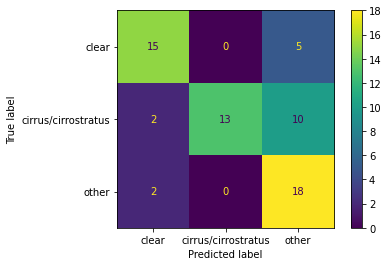

In [ ]:
## Make a Confusion Matrix 
## Import the functions
## Coded by Valerie
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score

## We want to see how accurate our model was in its predictions
accuracy = accuracy_score(true, predicted)
print("The accuracy score of the model is " + str(accuracy))

## We can also see how precise the model was 
precision = precision_score(true, predicted, average=None)
print("The precision score for predicting clear skies is " + str(precision[0]))
print("The precision score for predicting cirrus/cirrostratus cloud is " + str(precision[1]))
print("The precision score for predicting other cloud types is " + str(precision[2]))

## Make the confusion matrix
c = confusion_matrix(true, predicted, labels = [0, 1, 2])
display = ConfusionMatrixDisplay(c, display_labels=['clear', 'cirrus/cirrostratus', 'other']) ## Display the matrix and change the labels into something more understandable
display.plot()

Our model was about 71% accurate in classifying cloud images. It was most accurate in identifying other images, as only 2 of the 20 were misclassified. However, the precision score for other images was fairly low at only 55%. It seemed to think many of the cirrus/cirrostratus and clear images were actually other images. On the other hand, the precision score for cirrus/cirrostratus clouds was extremely high at 100%, but the accuracy score is fairly low since about half of the 25 images for cirrus and cirrostratus clouds were identified incorrectly. Classification of clear images was about even in regards to both precision and accuracy. The precision value sits at 79% while the accuracy value is closer to about 75% since 5 out of the 20 were misclassified. Overall, the model performed fairly well, but it could definitely use some improvement.

Now we can display classified and misclassified images by category. By looking at the correct and incorrect images side-by-side, we can see if there is a reason why the model might be misclassifying images.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


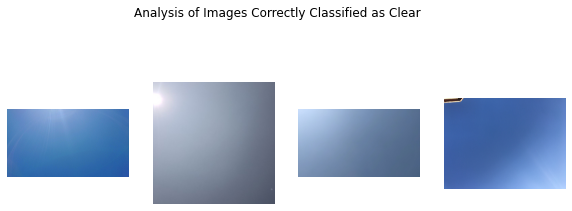

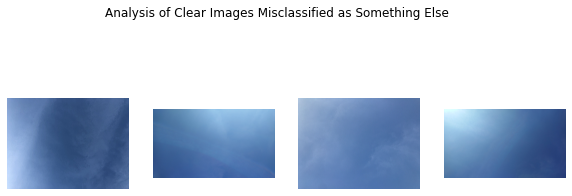

In [ ]:
## Comparison for clear images
## Create a figure
## Coded by Valerie
fig = plt.figure(figsize=(10, 7))
  
## Setting values to rows and column variables
rows = 2
columns = 4
  
## Reading in images for incorrectly classified polar lows
image_array = []
for image in cor_clear[0:4]: ## There are only 5 misclassified images, so we'll look at 4 correct and incorrect images
  image_array.append(Image.open('/content/gdrive/Shareddrives/FIRE-CC/FIRE198/Final Projects/TheFinalFour/Clear/' + image)) ## Looking for a file path, not just an image name
  
## Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
fig.suptitle("Analysis of Images Correctly Classified as Clear") ## Adds a larger, centered title on the plot
for i, image in enumerate(image_array): ## Loops through 4 images 
  fig.add_subplot(rows, columns, i+1) ## Arranges the images into rows and columns 
  plt.imshow(image)
  plt.axis('off')

fig.show()

## Same code as before but for incorrectly classified clear images
image_array = []
for image in mis_clear[0:4]:
  image_array.append(Image.open('/content/gdrive/Shareddrives/FIRE-CC/FIRE198/Final Projects/TheFinalFour/Clear/' + image))

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 1)
  
fig.suptitle("Analysis of Clear Images Misclassified as Something Else")
for i, image in enumerate(image_array):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(image)
  plt.axis('off')

fig.show()

It appears that some of the images flagged as misclassified are not actually misclassified. Though they were marked as clear images by those who submitted the data, these images actually do have some clouds in them. Some of the others appear to have some lens flare captured in them as well, which might lead to their misclassification if they were really clear images. Overall, the model did a good job of classifying clear images, since some of the images that were marked to be clear are not really clear, and the model picked up on that.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


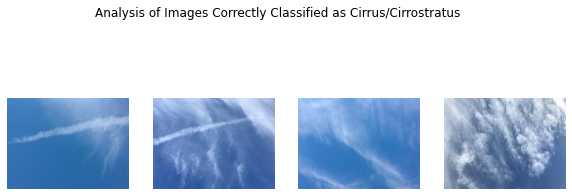

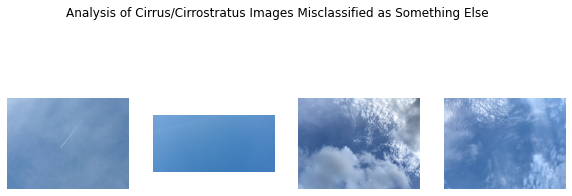

In [ ]:
## Comparison for cirrus/cirrostratus images
## Create a figure
## Coded by Valerie
fig = plt.figure(figsize=(10, 7))
  
## Setting values to rows and column variables
rows = 2
columns = 4
  
## Reading in images for incorrectly classified polar lows
image_array = []
for image in cor_clouds[0:4]: ## Once again we are going to look at 4 images from each
  image_array.append(Image.open('/content/gdrive/Shareddrives/FIRE-CC/FIRE198/Final Projects/TheFinalFour/Cirrus and Cirrostratus/' + image)) ## Looking for a file path, not just an image name
  
## Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
fig.suptitle("Analysis of Images Correctly Classified as Cirrus/Cirrostratus") ## Adds a larger, centered title on the plot
for i, image in enumerate(image_array): ## Loops through 4 images 
  fig.add_subplot(rows, columns, i+1) ## Arranges the images into rows and columns 
  plt.imshow(image)
  plt.axis('off')

fig.show()

## Same code as before but for incorrectly classified clear images
image_array = []
for image in mis_clouds[0:4]:
  image_array.append(Image.open('/content/gdrive/Shareddrives/FIRE-CC/FIRE198/Final Projects/TheFinalFour/Cirrus and Cirrostratus/' + image))

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 1)
  
fig.suptitle("Analysis of Cirrus/Cirrostratus Images Misclassified as Something Else")
for i, image in enumerate(image_array):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(image)
  plt.axis('off')

fig.show()

It appears as though one of the misclassifications isn't actually a misclassification. It was an image marked to be a cirrus/cirrostratus image, but it is actually a clear sky image to the model marked it as something else. The others do actually appear to be misclassifications. Some of them appear to have other clouds that are not cirrus or cirrostratus in them, which is probably why the model thought they were something else.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


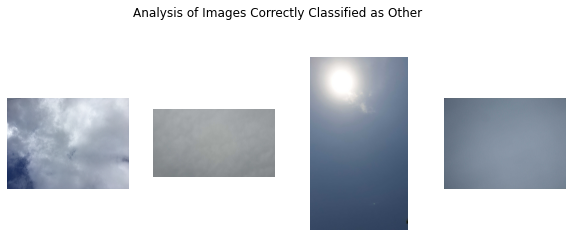

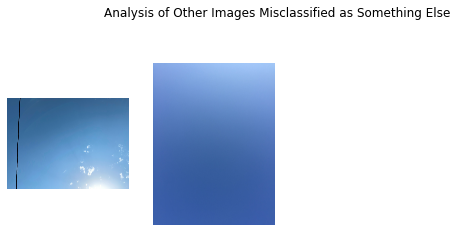

In [ ]:
## Comparison for other images
## Create a figure
## Coded by Valerie
fig = plt.figure(figsize=(10, 7))
  
## Setting values to rows and column variables
rows = 2
columns = 4
  
## Reading in images for incorrectly classified polar lows
image_array = []
for image in cor_other[0:4]: ## Once again we are going to look at 4 images from each
  image_array.append(Image.open('/content/gdrive/Shareddrives/FIRE-CC/FIRE198/Final Projects/TheFinalFour/Other/' + image)) ## Looking for a file path, not just an image name
  
## Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
fig.suptitle("Analysis of Images Correctly Classified as Other") ## Adds a larger, centered title on the plot
for i, image in enumerate(image_array): ## Loops through 4 images 
  fig.add_subplot(rows, columns, i+1) ## Arranges the images into rows and columns 
  plt.imshow(image)
  plt.axis('off')

fig.show()

## Same code as before but for incorrectly classified other images
image_array = []
for image in mis_other[0:2]: ## Only two images were misidentified
  image_array.append(Image.open('/content/gdrive/Shareddrives/FIRE-CC/FIRE198/Final Projects/TheFinalFour/Other/' + image))

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 1)
  
fig.suptitle("Analysis of Other Images Misclassified as Something Else")
for i, image in enumerate(image_array):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(image)
  plt.axis('off')

fig.show()

One of the images marked as misclassified is not actually an other image, but is a clear image. The model was correct in identifying that it was not an other image. The other misclassified image appears to have clouds in it, but there is some sort of obstruction in the image which might have led to its misclassification.

## Patterns in Metadata

Now that we've explored the classified and misclassified images, we can expand our analysis to include other columns present within the original dataframe to see how those categories might impact the way images are being classified. By making visuals of these columns' impact on our three categories, we can see if there are any trends that might point to a possible solution for our model.

First, we are going to subset the columns we want to look at into a new dataframe. We can do this individually for each of our three categories, then compile them into one larger dataframe of 65 rows.

In [ ]:
## Coded by Henry
clearUp_df["filepath"] = np.array(paths_of_clear) # adds filepath to clearUp
clearUp_df["Classification"] = np.array(clear_classification) # adds classification to clearUp

types_df["filepath"] = np.array(paths_of_clouds)# adds filepath to types (cirrus/cirrostratus)
types_df["Classification"] = np.array(clouds_classification)# adds classification to types (cirrus/cirrostratus)

other_types_df["filepath"] = np.array(paths_of_other)# adds filepath to other types
other_types_df["Classification"] = np.array(other_classification)# adds classification to other types


final_df = pd.concat([clearUp_df, types_df, other_types_df]) # concatenates the three dataframes on top of each other, in sorted order by cloud type.


In [ ]:
#Coded by Shraddha and Benjamin

final_df = final_df[['Is GLOBE Trained','Ground Image Up', 'is Citizen Science','Observation Latitude', 'Observation Longitude','Observation Elevation','Sky Visibility','Total Cloud Cover %', 'Cirrus', 'Cirrostratus', 'High Cloud Cover', 'High Cloud Opacity', 'Mid Cloud Cover', 'Mid Cloud Opacity', 'Low Cloud Cover', 'Low Cloud Opacity', 'filepath', 'Classification']]
print(final_df)

      Is GLOBE Trained                                    Ground Image Up  \
3152               1.0  https://data.globe.gov/system/photos/2020/01/0...   
3208               1.0  https://data.globe.gov/system/photos/2020/01/0...   
3211               1.0  https://data.globe.gov/system/photos/2020/01/0...   
3237               0.0  https://data.globe.gov/system/photos/2020/01/0...   
3265               1.0  https://data.globe.gov/system/photos/2020/01/0...   
...                ...                                                ...   
1031               0.0  https://data.globe.gov/system/photos/2020/01/0...   
1034               0.0  https://data.globe.gov/system/photos/2020/01/0...   
1041               0.0  https://data.globe.gov/system/photos/2020/01/0...   
1042               0.0  https://data.globe.gov/system/photos/2020/01/0...   
1047               1.0  https://data.globe.gov/system/photos/2020/01/0...   

      is Citizen Science  Observation Latitude  Observation Longitude  \
31

One column we are going to look at is the "Total Cloud Coverage %" column. Here we are making a bar chart that will show us how many misclassified images came from each cloud cover option within the column.

Text(0.5, 0, 'Total Cloud Cover %')

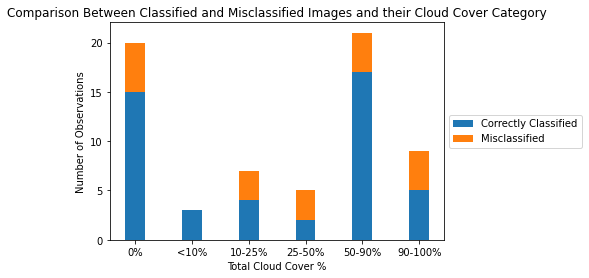

In [ ]:
## Make x labels for our graph
## Coded by Shraddha, Valerie, and Benjamin
final_df.replace(to_replace= "20-25%", value = "10-25%", inplace=True ) ## In the original dataframe, there was a typo in the category, so this fixes it
xlabels = ['0%', '<10%', '10-25%', '25-50%', '50-90%', '90-100%'] ## X labels for our graph

## Two new lists that will hold our numbers we can make into a stacked bar chart
## We are making a stacked bar chart, so we need two Y values of both incorrect and correct images
Y_cor = [len(final_df[(final_df['Total Cloud Cover %'] == '0') & (final_df['Classification'] == 'Correct')]), len(final_df[(final_df['Total Cloud Cover %'] == '< 10%') & (final_df['Classification'] == 'Correct')]), len(final_df[(final_df['Total Cloud Cover %'] == '10-25%') & (final_df['Classification'] == 'Correct')]), len(final_df[(final_df['Total Cloud Cover %'] == '25-50%') & (final_df['Classification'] == 'Correct')]), len(final_df[(final_df['Total Cloud Cover %'] == '50-90%') & (final_df['Classification'] == 'Correct')]), len(final_df[(final_df['Total Cloud Cover %'] == '90-100%') & (final_df['Classification'] == 'Correct')])]
Y_incor = [len(final_df[(final_df['Total Cloud Cover %'] == '0') & (final_df['Classification'] == 'Incorrect')]), len(final_df[(final_df['Total Cloud Cover %'] == '< 10%') & (final_df['Classification'] == 'Incorrect')]), len(final_df[(final_df['Total Cloud Cover %'] == '10-25%') & (final_df['Classification'] == 'Incorrect')]), len(final_df[(final_df['Total Cloud Cover %'] == '25-50%') & (final_df['Classification'] == 'Incorrect')]), len(final_df[(final_df['Total Cloud Cover %'] == '50-90%') & (final_df['Classification'] == 'Incorrect')]), len(final_df[(final_df['Total Cloud Cover %'] == '90-100%') & (final_df['Classification'] == 'Incorrect')])]
width = 0.35

## Making the plot
## Use 'bottom = Y_cor' so it stacks
plt.bar(xlabels, Y_cor, width, label = 'Correctly Classified')
plt.bar(xlabels, Y_incor, width, bottom = Y_cor, label = 'Misclassified')

## Plot customization
## Add a legend, title, etc
plt.legend(loc=0)
plt.yticks(range(0, 21, 5)) ## This will turn our y axis into integers rather than floats
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Comparison Between Classified and Misclassified Images and their Cloud Cover Category')
plt.ylabel('Number of Observations')
plt.xlabel('Total Cloud Cover %')

It looks as though there was some misidentification in all of the categories (except '< 10%'). Though there were only around 5 images marked as '25-50%', half of them came to be misclassified by the model. This may indicate that this category contributes to the problem, but with only 5 images to choose from, it is hard to tell how much of an impact it really has. Similarly, since only 20 to 25 images were selected from each sub-category of clouds, this data may or may not provide an accurate representation of the entire dataset.

## Conclusion

Throughout this deliverable, we successfully ran the model, made visuals to represent its current condition, and looked at some of the metadata to see how it impacts the classifications. We completed this by subsetting the data into a smaller dataframe and downloading cloud images to our Google Drive. We then were able to run these images through our model and store the classifications into lists that we could manipulate into a confusion matrix and other visual images. The confusion matrix showed that the overall accuracy of the model was around 71%. Although this is fairly accurate, it was evident that our cloud-type images, Cirrus and Cirrostratus, along with even clear images were misclassified as being “other” image cloud types. Our group believed that columns such as “Total Cloud Coverage %” should be used to compare the amount of classified and misclassified images based on the amount of cloud coverage in each of them. We successfully implemented a stacked bar graph to highlight this information, and in the end, we were able to observe that the model was fairly accurate and its data wasn’t impacted drastically from columns like that of the total amount of cloud coverages.

While completing the deliverable, our team ran into several issues. The first problem that we encountered was the idea of having to clean our data. Our group immediately noticed that many of the data/images that were being fed into the teachable machine were misclassified before the model could even look at them. The images that were used for our model also had different image sizes, which was the main cause of our prediction model printing out peculiar prediction values at the start of our deliverable. Finally, a major limitation our group had was time. Our group originally planned on completing a step within our deliverable centered around K-means clustering, as mentioned in our introduction. However, we were not able to implement this step onto our deliverable due to us having tight schedules throughout the week and a half period we had to work on our final project. 

Based on our findings, our team has discovered that many of the current issues with the model are not so much with the model itself, but instead with the data being fed into it. Many of the images have incorrect truth labels (saying a clear image is a cloud image) and have been incorrectly placed in the wrong categories. The model was actually able to pick up on this, and correctly misclassified images. We were unable to find many faults with the model itself, and suggest that future teams try to include a larger data set to see if the "Total Cloud Cover %" category plays a larger impact on misclassification. Future research on this topic should also look through other metadata to see if there are any patterns since we were only able to look at the one column due to time constraints. We also think it would be a good idea to try K-Means Clustering on the data to see if that reveals any information.

Overall, we believe the model is more accurate than it appears to be. In order to fix this in the future, incorrectly identified images should be subsetted into a new dataframe where they can then be sorted through manually to see how many citizen-submitted images were actually misclassified. For further research, it might be beneficial to manually sort through the images going to be fed into the teachable machine to make sure they are marked correctly.